In [203]:
import pandas as pd
from tqdm import tqdm
import numpy as np


class StrategyReturnsCalculator:
    def __init__(self, long_weights: pd.DataFrame, short_weights: pd.DataFrame,
                 prices_data_preprocessed: pd.DataFrame,
                 predicted_regimes: pd.DataFrame,
                 implementation_days_delta: int = 0, is_long_only: bool = True,
                 transaction_fee: float = 0.001) -> None:
        """
        Initialize the StrategyReturnsCalculator.

        Parameters:
        long_weights (pd.DataFrame): DataFrame of long position weights.
        short_weights (pd.DataFrame): DataFrame of short position weights (if applicable).
        prices_data_preprocessed (pd.DataFrame): Preprocessed DataFrame of prices.
        predicted_regimes (pd.DataFrame): DataFrame of predicted regimes for weight allocation.
        implementation_days_delta (int): Days to shift weights for implementation.
        is_long_only (bool): Flag indicating if the strategy is long-only.
        transaction_fee (float): Transaction fee rate.
        """
        self.long_weights = self._verify_datetime_index(long_weights)
        self.short_weights = self._verify_datetime_index(short_weights) if not is_long_only else None
        self.prices_data_preprocessed = self._verify_datetime_index(prices_data_preprocessed)
        self.predicted_regimes = self._verify_datetime_index(predicted_regimes)
        self.daily_returns = self.prices_data_preprocessed.pct_change().iloc[1:]
        self.is_long_only = is_long_only
        self.transaction_fee = transaction_fee
        self.implementation_days_delta = implementation_days_delta
        self.drifted_weights_long = None
        self.drifted_weights_short = None

    @staticmethod
    def _verify_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
        """
        Ensure the DataFrame index is a DatetimeIndex.

        Parameters:
        df (pd.DataFrame): DataFrame to check.

        Returns:
        pd.DataFrame: DataFrame with DatetimeIndex.
        """
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        return df

    def calculate_drifted_weights(self) -> None:
        """
        Calculate drifted weights for long and short positions.
        """
        self.drifted_weights_long = self._get_drifted_weights(self.long_weights)
        if not self.is_long_only:
            self.drifted_weights_short = self._get_drifted_weights(self.short_weights)

    def concat_daily_returns_with_risk_free_rates(self, risk_free_rates: pd.DataFrame) -> pd.DataFrame:
        """
        Concatenate daily returns with risk-free rates.

        Parameters:
        risk_free_rates (pd.DataFrame): DataFrame containing the risk-free rates.

        Returns:
        pd.DataFrame: DataFrame with daily returns and reindexed risk-free rates.
        """
        risk_free_rates_shifted = risk_free_rates.shift(1)
        risk_free_rates_reindexed = risk_free_rates_shifted.reindex(self.daily_returns.index).fillna(0)
        self.daily_returns = pd.concat([self.daily_returns, risk_free_rates_reindexed], axis=1).dropna(axis=0, how='any')
        return self.daily_returns

    def _get_drifted_weights(self, weights: pd.DataFrame) -> pd.DataFrame:
        """
        Get drifted weights adjusted for implementation delay.

        Parameters:
        weights (pd.DataFrame): DataFrame of weights to drift.

        Returns:
        pd.DataFrame: DataFrame of drifted weights.
        """
        weights_aligned, daily_returns = weights.align(self.daily_returns, axis=1, join='inner')
        weights_aligned.index += pd.Timedelta(days=self.implementation_days_delta)
        weights_aligned.fillna(0, inplace=True)

        aligned_start_date = max(weights_aligned.index.min(), daily_returns.index.min())
        daily_returns = daily_returns.loc[aligned_start_date:]
        weights_aligned = weights_aligned.loc[aligned_start_date:]

        drifted_weights = pd.DataFrame(index=daily_returns.index, columns=weights_aligned.columns)
        current_weights = weights_aligned.iloc[0]
        drifted_weights.iloc[0] = current_weights

        for date in tqdm(daily_returns.index[1:], desc="Calculating drifted weights"):
            if date in weights_aligned.index:
                current_weights = weights_aligned.loc[date]
            else:
                return_factor = (1 + daily_returns.loc[date]) if self.is_long_only else (1 - daily_returns.loc[date])
                daily_change = current_weights * return_factor
                daily_change[daily_returns.loc[date].isna()] = 0
                #Why do we normalize only when there is more than one stock?
                if (current_weights != 0).sum() > 1:
                    current_weights = daily_change / abs(daily_change).sum()
                else:
                    current_weights = daily_change
                   

            drifted_weights.loc[date] = current_weights

        return drifted_weights

    def compute_strategy_returns(self) -> pd.DataFrame:
        """
        Compute the overall portfolio returns.

        Returns:
        pd.DataFrame: DataFrame of portfolio returns.
        """
        start_date = self.long_weights.index[0]
        daily_returns = self.daily_returns.loc[start_date:]
        
        strategy_returns_long = (self.drifted_weights_long.shift(1) * daily_returns).sum(axis=1)
        strategy_returns = strategy_returns_long
        if not self.is_long_only:
            strategy_returns_short = (self.drifted_weights_short.shift(1) * daily_returns).sum(axis=1)
            #Modify this to combine the portfolio returns using the Statistical jump model
            strategy_returns += strategy_returns_short

        portfolio_returns = pd.DataFrame(strategy_returns, columns=["Portfolio_Returns"])
        transaction_costs = self._calculate_transaction_costs_at_rebalance_dates()
        portfolio_returns["Portfolio_Returns"] -= transaction_costs

        portfolio_returns["Portfolio_Returns"] = pd.to_numeric(portfolio_returns["Portfolio_Returns"], errors='coerce')

        return portfolio_returns

    def _calculate_transaction_costs_at_rebalance_dates(self) -> pd.Series:
        """
        Calculate transaction costs at rebalance dates.

        Returns:
        pd.Series: Series of transaction costs.
        """
        transaction_costs = pd.Series(0.0, index=self.prices_data_preprocessed.index)

        for date_pos, date in enumerate(tqdm(self.long_weights.index, desc="Calculating transaction costs")):
            prev_date_pos = date_pos - 1

            if prev_date_pos < 0:
                continue

            current_weights_long = self.drifted_weights_long.iloc[date_pos]
            prev_weights_long = self.drifted_weights_long.iloc[prev_date_pos]
            weight_changes_long = np.abs(current_weights_long - prev_weights_long)
            transaction_costs_long = weight_changes_long.sum() * self.transaction_fee

            if not self.is_long_only:
                current_weights_short = self.drifted_weights_short.iloc[date_pos]
                prev_weights_short = self.drifted_weights_short.iloc[prev_date_pos]
                weight_changes_short = np.abs(current_weights_short - prev_weights_short)
                transaction_costs_short = weight_changes_short.sum() * self.transaction_fee
                total_transaction_costs = transaction_costs_long + transaction_costs_short
            else:
                total_transaction_costs = transaction_costs_long

            transaction_costs[date] = total_transaction_costs

        return transaction_costs

In [204]:

# Simulated monthly weights for rebalancing (replace with monthly weight matrix)
rebalance_dates = pd.date_range(start="2023-01-01", end="2023-03-31", freq='BME')  # Last business day of each month
weights = {
    'GOOGL': [0.8, -0.1, -0.4],
    'AAPL': [-0.1, 0.8, -0.9],
    'TSLA': [-0.3, 0.8, 1.8],
    'GME': [0.6, -0.5, 0.5]
} 
monthly_weights = pd.DataFrame(weights, index=rebalance_dates, columns=["AAPL", "GOOGL", "TSLA","GME"])

# Split long and short portfolios
long_weights = monthly_weights.where(monthly_weights > 0, 0) 
short_weights = monthly_weights.where(monthly_weights < 0, 0)  

# Normalize weights
long_weights = long_weights.div(long_weights.abs().sum(axis=1), axis=0).fillna(0)
short_weights = short_weights.div(short_weights.abs().sum(axis=1), axis=0).fillna(0)

print(long_weights)
print(short_weights)


            AAPL     GOOGL      TSLA       GME
2023-01-31   0.0  0.571429  0.000000  0.428571
2023-02-28   0.5  0.000000  0.500000  0.000000
2023-03-31   0.0  0.000000  0.782609  0.217391
                AAPL     GOOGL  TSLA       GME
2023-01-31 -0.250000  0.000000 -0.75  0.000000
2023-02-28  0.000000 -0.166667  0.00 -0.833333
2023-03-31 -0.692308 -0.307692  0.00  0.000000


In [205]:
# Simulated daily prices (replace with daily prices file)
dates = pd.bdate_range(start='2023-01-01', end='2023-03-31')
np.random.seed(42)
prices_data = {
    'AAPL': np.random.uniform(140, 160, len(dates)),  
    'GOOGL': np.random.uniform(2600, 2800, len(dates)), 
    'GME': np.random.uniform(150, 200, len(dates)),
    'TSLA': np.random.uniform(850, 950, len(dates))
}
daily_prices_test = pd.DataFrame(prices_data, index=dates)

print(daily_prices_test)

                  AAPL        GOOGL         GME        TSLA
2023-01-02  147.490802  2708.539217  170.870550  884.920957
2023-01-03  159.014286  2628.184845  161.105391  922.595568
2023-01-04  154.639879  2760.439396  155.993268  939.711026
2023-01-05  151.973170  2614.910129  166.880759  938.708642
2023-01-06  143.120373  2797.377387  197.145485  927.987555
...                ...          ...         ...         ...
2023-03-27  147.773546  2685.421558  154.655138  905.680126
2023-03-28  145.426981  2763.602953  194.860788  943.615477
2023-03-29  156.574750  2772.146117  195.020903  919.602980
2023-03-30  147.135067  2601.390426  181.655073  907.006117
2023-03-31  145.618690  2702.149461  166.951490  859.717649

[65 rows x 4 columns]


In [206]:
import pandas as pd
import numpy as np

# Simulate long short weights

start_date = '2000-01-01'
end_date = '2023-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='BME')

# Generate monthly end dates that fall on business days
month_end_dates = date_range[date_range.isin(pd.date_range(start=start_date, end=end_date, freq='ME'))]

# Create a DataFrame to hold long and short portfolio weights
data = {
    'long': np.random.uniform(0.7, 1.0, len(month_end_dates)),  # Long weights between 70% and 100%
    'short': np.random.uniform(0, 0.3, len(month_end_dates))  # Short weights between 0% and 30%
}

long_short_alloc = pd.DataFrame(data, index=month_end_dates)

# Normalize long weights to sum to 1
long_short_alloc['long'] /= long_short_alloc['long'].sum()

# Normalize short weights to sum to a maximum of -30%
long_short_alloc['short'] /= long_short_alloc['short'].sum()
long_short_alloc['short'] *= -0.1  # Make short weights negative

# Adjust the long weights to ensure they sum to 1
total_weights = long_short_alloc['long'] + long_short_alloc['short']
long_short_alloc['long'] = long_short_alloc['long'] / total_weights
long_short_alloc['short'] = long_short_alloc['short'] / total_weights

# Display the resulting DataFrame
print(long_short_alloc)


                long     short
2000-01-31  1.204610 -0.204610
2000-02-29  1.040356 -0.040356
2000-03-31  1.289535 -0.289535
2000-05-31  1.002463 -0.002463
2000-06-30  1.210893 -0.210893
...              ...       ...
2023-06-30  1.056388 -0.056388
2023-07-31  1.035487 -0.035487
2023-08-31  1.186085 -0.186085
2023-10-31  1.017378 -0.017378
2023-11-30  1.130538 -0.130538

[207 rows x 2 columns]


In [207]:
# Initialize the StrategyReturnsCalculator
calculator = StrategyReturnsCalculator(
    long_weights=long_weights, 
    short_weights=short_weights,  # Set to None if long-only
    prices_data_preprocessed=daily_prices, 
    predicted_regimes=long_short_alloc,
    implementation_days_delta=0,  # Set to the number of days delay for implementation, if needed
    is_long_only=False  # Set to True if long-only strategy
)

/var/folders/gf/tz3v9rjd71x7qmg88v6462780000gn/T/ipykernel_10673/3513840697.py:28: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.daily_returns = self.prices_data_preprocessed.pct_change().iloc[1:]


In [208]:
# Calculate the drifted weights
calculator.calculate_drifted_weights()

# Access the drifted weights
drifted_weights_long = calculator.drifted_weights_long
drifted_weights_short = calculator.drifted_weights_short if not calculator.is_long_only else None

print(drifted_weights_long)
print(drifted_weights_short)

Calculating drifted weights: 100%|██████████| 230/230 [00:00<00:00, 849.30it/s]

           AAPL     GOOGL      TSLA       GME
date                                         
2023-01-31  0.0  0.571429       0.0  0.428571
2023-02-01  0.0  0.567004       0.0  0.432996
2023-02-02  0.0  0.558416       0.0  0.441584
2023-02-03  0.0  0.560258       0.0  0.439742
2023-02-06  0.0     0.583       0.0     0.417
...         ...       ...       ...       ...
2023-12-22  0.0       0.0   0.71854   0.28146
2023-12-26  0.0       0.0  0.719954  0.280046
2023-12-27  0.0       0.0  0.728133  0.271867
2023-12-28  0.0       0.0  0.731074  0.268926
2023-12-29  0.0       0.0  0.728895  0.271105

[231 rows x 4 columns]
                AAPL     GOOGL      TSLA  GME
date                                         
2023-01-31     -0.25       0.0     -0.75  0.0
2023-02-01 -0.257671       0.0 -0.742329  0.0
2023-02-02  -0.25782       0.0  -0.74218  0.0
2023-02-03 -0.254851       0.0 -0.745149  0.0
2023-02-06 -0.263151       0.0 -0.736849  0.0
...              ...       ...       ...  ...
2023-12-22

In [209]:
# Calculate the final daily weight in each stock with long/short allocation

aligned_start_date_ls = max(drifted_weights_long.index.min(), long_short_weights.index.min())
daily_returns = daily_returns.loc[aligned_start_date:]
weights_aligned = weights_aligned.loc[aligned_start_date:]


NameError: name 'weights_aligned' is not defined

In [200]:
# Import the real stock prices data

daily_prices = pd.read_csv('../data/intermediate_data/preprocess_data/stocks_prices_df_preprocessed.csv',index_col=0)
daily_prices.index = pd.to_datetime(daily_prices.index)
print(daily_prices.head())

                DITC      JBL     CNCX      SFY  IRBT    NTCT      DRTE  \
date                                                                      
2000-01-03   97.8750  69.4375  31.6250  10.2500   NaN  29.000  30.84375   
2000-01-04  119.0000  64.6250  29.3750  10.0000   NaN  26.625  30.00000   
2000-01-05  118.1875  64.5000  29.6875   9.8750   NaN  26.750  29.50000   
2000-01-06  119.5000  62.4375  28.2500  10.7500   NaN  27.500  27.43750   
2000-01-07  120.5625  64.6250  30.0000  10.9375   NaN  26.500  30.06250   

               VIRS       OLN  SLH  ...     ELNT  VIRT     OCLI      WTNY  \
date                                ...                                     
2000-01-03  13.0000  18.93750  NaN  ...  29.9375   NaN  342.875  36.65625   
2000-01-04  13.0000  18.87500  NaN  ...  27.4375   NaN  311.000  35.93750   
2000-01-05  14.0000  20.12500  NaN  ...  27.9375   NaN  287.000  36.18750   
2000-01-06  15.4375  20.84375  NaN  ...  27.0000   NaN  274.000  36.12500   
2000-01-07  

In [168]:
index_type = type(overall_portfolio_weights_aligned.index)
print(index_type)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [167]:
# Inputs should be the long and short portfolios and the allocation df and the daily prices
# Outputs should be drifted weights of overall portfolio, drifted weights of long and short portfolios, and performance of total portfolio
# Do they also want me to add the performance of long and short portfolios?

#Input short allocation dataframe (assuming the short allocation is positive and we want to transform into negative with additional long column)
# Assuming the SJM output is a series called short_allocation

long_short_alloc = pd.DataFrame({
    'long': 1 + short_allocation.abs(),
    'short': -short_allocation
long_short_alloc = pd.to_datetime(long_short_alloc.index)

#Integrate the long/short allocation from the statistical jump model

print(long_weights)
print(short_weights)
print(long_short_alloc)

#Make sure long and short portfolio dataframes have the columns aligned
long_weights, short_weights = long_weights.align(short_weights, axis=1, join='outer', fill_value=0)

   #Align the start dates
aligned_start_date = max(long_weights.index.min(), long_short_alloc.index.min(),short_weights.index.min())
long_weights = long_weights.loc[aligned_start_date:]
short_weights = short_weights.loc[aligned_start_date:]
long_short_alloc = long_short_alloc.loc[aligned_start_date:]
print(long_weights)
print(long_short_alloc)

# Calculate the overall portfolio rebalancing weights
adjusted_long_weights = long_weights.multiply(long_short_alloc['long'], axis=0)
print(adjusted_long_weights.head())
adjusted_short_weights = short_weights.multiply(abs(long_short_alloc['short']), axis=0)
print(adjusted_short_weights.head())

overall_portfolio_weights = adjusted_long_weights.add(adjusted_short_weights, fill_value=0)
print(overall_portfolio_weights.head())



            AAPL     GOOGL      TSLA       GME
2023-01-31   0.0  0.571429  0.000000  0.428571
2023-02-28   0.5  0.000000  0.500000  0.000000
2023-03-31   0.0  0.000000  0.782609  0.217391
                AAPL     GOOGL  TSLA       GME
2023-01-31 -0.250000  0.000000 -0.75  0.000000
2023-02-28  0.000000 -0.166667  0.00 -0.833333
2023-03-31 -0.692308 -0.307692  0.00  0.000000
                long     short
2023-01-31  1.038293 -0.038293
2023-02-28  1.061379 -0.061379
2023-03-31  1.039284 -0.039284
2023-05-31  1.037414 -0.037414
2023-06-30  1.056388 -0.056388
2023-07-31  1.035487 -0.035487
2023-08-31  1.186085 -0.186085
2023-10-31  1.017378 -0.017378
2023-11-30  1.130538 -0.130538
            AAPL     GOOGL      TSLA       GME
2023-01-31   0.0  0.571429  0.000000  0.428571
2023-02-28   0.5  0.000000  0.500000  0.000000
2023-03-31   0.0  0.000000  0.782609  0.217391
                long     short
2023-01-31  1.038293 -0.038293
2023-02-28  1.061379 -0.061379
2023-03-31  1.039284 -0.039284
20

In [166]:

# Arithmetic returns
daily_returns = daily_prices.pct_change(fill_method=None)
print(daily_returns)

# Align the columns of the overall portfolio weights and daily returns
print("Overall Portfolio Weights:")
print(overall_portfolio_weights.head())
print("\nDaily Returns:")

print(daily_returns.head())

overall_portfolio_weights_aligned, daily_returns_aligned = overall_portfolio_weights.align(daily_returns, axis=1, join='inner')
overall_portfolio_weights_aligned.fillna(0, inplace=True)

print("Weights Aligned:")
print(overall_portfolio_weights_aligned)
print("\nDaily Returns Aligned:")
print(daily_returns_aligned)

# Align the start dates of the dataframes
aligned_start_date2 = max(overall_portfolio_weights_aligned.index.min(), daily_returns_aligned.index.min())
overall_portfolio_weights_aligned = overall_portfolio_weights_aligned.loc[aligned_start_date2:]
daily_returns_aligned = daily_returns_aligned.loc[aligned_start_date2:]

print("Aligned Start Date:")
print(overall_portfolio_weights_aligned)
print(daily_returns_aligned)



                DITC       JBL      CNCX       SFY      IRBT      NTCT  \
date                                                                     
2000-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2000-01-04  0.215837 -0.069307 -0.071146 -0.024390       NaN -0.081897   
2000-01-05 -0.006828 -0.001934  0.010638 -0.012500       NaN  0.004695   
2000-01-06  0.011105 -0.031977 -0.048421  0.088608       NaN  0.028037   
2000-01-07  0.008891  0.035035  0.061947  0.017442       NaN -0.036364   
...              ...       ...       ...       ...       ...       ...   
2023-12-22       NaN -0.006757       NaN  0.007338  0.012704  0.005809   
2023-12-26       NaN  0.004457       NaN  0.027402 -0.017665 -0.000888   
2023-12-27       NaN -0.007785       NaN -0.017218  0.010685 -0.008448   
2023-12-28       NaN  0.004158       NaN -0.012367 -0.005673 -0.006726   
2023-12-29       NaN -0.004532       NaN  0.011478  0.003631 -0.009029   

                DRTE      VIRS       

In [155]:
# Now our columns and start dates are aligned

print(overall_portfolio_weights_aligned)
print(daily_returns_aligned)

# Initialize the drifted weights dataframe

drifted_weights = pd.DataFrame(index=daily_returns_aligned.index, columns=overall_portfolio_weights_aligned.columns)
start_weights = overall_portfolio_weights_aligned.iloc[0]
drifted_weights.iloc[0] = start_weights



                AAPL     GOOGL      TSLA       GME
2023-01-31 -0.009573  0.593310 -0.028720  0.444983
2023-02-28  0.530690 -0.010230  0.530690 -0.051150
2023-03-31 -0.027197 -0.012088  0.813353  0.225931
2023-05-31  0.000000  0.000000  0.000000  0.000000
2023-06-30  0.000000  0.000000  0.000000  0.000000
2023-07-31  0.000000  0.000000  0.000000  0.000000
2023-08-31  0.000000  0.000000  0.000000  0.000000
2023-10-31  0.000000  0.000000  0.000000  0.000000
2023-11-30  0.000000  0.000000  0.000000  0.000000
                AAPL     GOOGL      TSLA       GME
date                                              
2023-01-31  0.009021  0.019600  0.039362  0.029176
2023-02-01  0.007901  0.016087  0.047281 -0.001829
2023-02-02  0.037063  0.072787  0.037815  0.039853
2023-02-03  0.024400 -0.027474  0.009083 -0.019824
2023-02-06 -0.017929 -0.017942  0.025160  0.072360
...              ...       ...       ...       ...
2023-12-22 -0.005547  0.007620 -0.007701 -0.000589
2023-12-26 -0.002841  0.000212 

In [180]:
#Calculating the dirfted weights with one df as input (df already includes sjm) and prices data

for date in tqdm(daily_returns_aligned.index[1:], desc="Calculating drifted weights"):
    if date in overall_portfolio_weights_aligned.index:
        new_weights = overall_portfolio_weights_aligned.loc[date]
    else:
        return_factor = (1 + daily_returns_aligned.loc[date])
        previous_date = drifted_weights.index[drifted_weights.index.get_loc(date) - 1]
        previous_weights = drifted_weights.loc[previous_date]
        new_weights = previous_weights * return_factor
        new_weights[daily_returns_aligned.loc[date].isna()] = 0
        if abs(new_weights).sum() != 0:
            new_weights = new_weights / abs(new_weights).sum()

    drifted_weights.loc[date] = new_weights

print(drifted_weights)

# Cut the dataframe so it only contains the month following the last rebalancing date (in case the returns data is longer than the weights data)

cutoff_date = overall_portfolio_weights.index[-1] + pd.offsets.MonthBegin(1) + pd.offsets.MonthEnd(1) - pd.offsets.BDay(1)
drifted_weights = drifted_weights.loc[:cutoff_date]

print(drifted_weights)

# Separate and normalize the long and short portfolio drifted weights

#Normalize function
def normalize_row(row):
    row_sum = row.sum()
    if row_sum != 0:
        return row / row_sum
    return row

# Note that the short weights are displayed as positive values
short_drifted_weights = drifted_weights.where(drifted_weights < 0, 0)
short_drifted_weights = short_drifted_weights.apply(normalize_row, axis=1)


long_drifted_weights = drifted_weights.where(drifted_weights > 0, 0)
long_drifted_weights = long_drifted_weights.apply(normalize_row, axis=1)


print(short_drifted_weights)
print(long_drifted_weights)


Calculating drifted weights: 100%|██████████| 230/230 [00:00<00:00, 270.89it/s]

                AAPL     GOOGL      TSLA       GME
date                                              
2023-01-31 -0.009573   0.59331  -0.02872  0.444983
2023-02-01 -0.008879  0.554732 -0.027677  0.408713
2023-02-02 -0.008703  0.562463 -0.027148  0.401687
2023-02-03 -0.009124  0.559863 -0.028038  0.402975
2023-02-06 -0.008788  0.539219 -0.028189  0.423804
...              ...       ...       ...       ...
2023-12-22       0.0       0.0       0.0       0.0
2023-12-26       0.0       0.0       0.0       0.0
2023-12-27       0.0       0.0       0.0       0.0
2023-12-28       0.0       0.0       0.0       0.0
2023-12-29       0.0       0.0       0.0       0.0

[231 rows x 4 columns]
                AAPL     GOOGL      TSLA       GME
date                                              
2023-01-31 -0.009573   0.59331  -0.02872  0.444983
2023-02-01 -0.008879  0.554732 -0.027677  0.408713
2023-02-02 -0.008703  0.562463 -0.027148  0.401687
2023-02-03 -0.009124  0.559863 -0.028038  0.402975
2023-02

In [174]:
# Compute Overall Portfolio Daily Returns

print(drifted_weights)
print(daily_returns_aligned)

strategy_returns = (drifted_weights.shift(1) * daily_returns_aligned).sum(axis=1)
strategy_returns.iloc[0] = np.nan
print(strategy_returns)

                AAPL     GOOGL      TSLA       GME
date                                              
2023-01-31 -0.009573   0.59331  -0.02872  0.444983
2023-02-01 -0.008879  0.554732 -0.027677  0.408713
2023-02-02 -0.008703  0.562463 -0.027148  0.401687
2023-02-03 -0.009124  0.559863 -0.028038  0.402975
2023-02-06 -0.008788  0.539219 -0.028189  0.423804
...              ...       ...       ...       ...
2023-12-22       0.0       0.0       0.0       0.0
2023-12-26       0.0       0.0       0.0       0.0
2023-12-27       0.0       0.0       0.0       0.0
2023-12-28       0.0       0.0       0.0       0.0
2023-12-29       0.0       0.0       0.0       0.0

[231 rows x 4 columns]
                AAPL     GOOGL      TSLA       GME
date                                              
2023-01-31  0.009021  0.019600  0.039362  0.029176
2023-02-01  0.007901  0.016087  0.047281 -0.001829
2023-02-02  0.037063  0.072787  0.037815  0.039853
2023-02-03  0.024400 -0.027474  0.009083 -0.019824
2023-02

In [196]:
# Import Sector data

sector_data = pd.read_csv('../data/raw_data/mapping_stocks_country_df_preprocessed.csv', index_col=0)
sector_data = sector_data[['ticker_name', 'Sector']]
sector_data['Sector'] = sector_data['Sector'].str.split(',').str[0]
print(sector_data)


def calculate_sector_weights(weights_df, sector_data):
    """
    Calculate the normalized sector weights from a weights DataFrame and a sector DataFrame.
    
    Parameters:
    weights_df (pd.DataFrame): DataFrame containing weights with dates as index and tickers as columns.
    sector_data (pd.DataFrame): DataFrame containing sector information with 'ticker_name' and 'Sector' columns.
    
    Returns:
    pd.DataFrame: Normalized sector weights DataFrame.
    """

    melted_weights = weights_df.reset_index().melt(id_vars=weights_df.index.name, var_name='ticker', value_name='weight')
    melted_weights.rename(columns={weights_df.index.name: 'date'}, inplace=True)
    merged_data = melted_weights.merge(sector_data, left_on='ticker', right_on='ticker_name', how='left')
    sector_weights = merged_data.groupby(['date', 'Sector'])['weight'].sum().unstack(fill_value=0)
    sector_weights_normalized = sector_weights.div(sector_weights.sum(axis=1), axis=0).fillna(0)
    sector_weights_normalized.index = weights_df.index
    return sector_weights_normalized

# Calculate sector weights for long and short portfolios

short_sector_weights = calculate_sector_weights(short_drifted_weights, sector_data)
long_sector_weights = calculate_sector_weights(long_drifted_weights, sector_data)

print(short_sector_weights)
print(long_sector_weights)  


     ticker_name           Sector
0              A         Consumer
1             AA  Basic Materials
2            AAL         Consumer
3            AAN         Consumer
4           AAON       Industrial
...          ...              ...
3560       FCE/A        Financial
3561       HUB/B       Industrial
3562        JW/A         Consumer
3563       NMG/A         Consumer
3564       STZ/B         Consumer

[3404 rows x 2 columns]
Sector      Communications  Consumer  Technology
date                                            
2023-01-31             0.0  0.750000    0.250000
2023-02-01             0.0  0.757117    0.242883
2023-02-02             0.0  0.757251    0.242749
2023-02-03             0.0  0.754471    0.245529
2023-02-06             0.0  0.762338    0.237662
...                    ...       ...         ...
2023-12-22             0.0  0.000000    0.000000
2023-12-26             0.0  0.000000    0.000000
2023-12-27             0.0  0.000000    0.000000
2023-12-28             0.0  

<Figure size 1200x600 with 0 Axes>

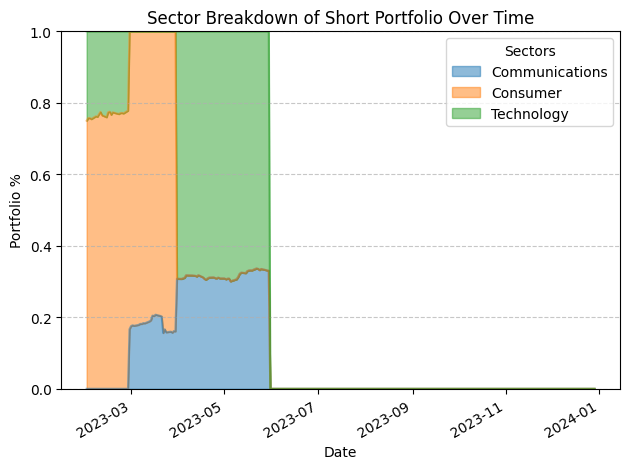

<Figure size 1200x600 with 0 Axes>

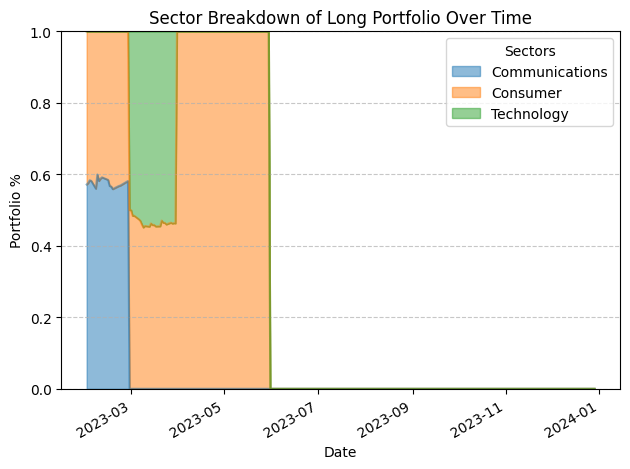

In [201]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_stacked_area(df, title='Sector Breakdown of Portfolio Over Time', xlabel='Date', ylabel='Portfolio %', figsize=(12, 6)):
    """
    Create a stacked area plot for the sector weights DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing sector weights with dates as index and sectors as columns.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    figsize (tuple): Size of the figure.
    """

    plt.figure(figsize=figsize)
    df.plot(kind='area', alpha=0.5, stacked=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Sectors')
    plt.tight_layout()
    plt.show()


# Show long and short portfolio sector weights
plot_stacked_area(short_sector_weights,title = 'Sector Breakdown of Short Portfolio Over Time')
plot_stacked_area(long_sector_weights, title = 'Sector Breakdown of Long Portfolio Over Time')



In [214]:
# Top 10 holdings

def top_10_holdings(drifted_weights):
    """
    Calculate the top 10 stock holdings based on average weights from drifted weights.

    Parameters:
    drifted_weights (pd.DataFrame): DataFrame containing the portfolio weights with tickers as columns.

    Returns:
    pd.DataFrame: A DataFrame containing the top 10 holdings, their average weights, and position (Long/Short).
    """
    average_weights = drifted_weights.mean()
    avg_weights_df = pd.DataFrame(average_weights).reset_index()
    avg_weights_df.columns = ['Ticker', 'Average Weight']
    avg_weights_df['Position'] = avg_weights_df['Average Weight'].apply(
        lambda x: 'Long' if x > 0 else 'Short'
    )
    avg_weights_df['Abs Weight'] = avg_weights_df['Average Weight'].abs()
    top_10 = avg_weights_df.sort_values(by='Abs Weight', ascending=False).head(10)
    top_10.reset_index(drop=True, inplace=True)
    top_10.index = top_10.index + 1  # Shift index to start from 1
    return top_10[['Ticker', 'Average Weight', 'Position']]



top_10 = top_10_holdings(drifted_weights)
print(top_10)






  Ticker Average Weight Position
1   TSLA       0.171949     Long
2    GME       0.068582     Long
3   AAPL       0.044293     Long
4  GOOGL       0.042229     Long
